In [4]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
hol_df = pd.read_csv("holidays_events.csv")
stores_df = pd.read_csv("stores.csv")
oil_df = pd.read_csv("oil.csv")
trans_df = pd.read_csv("transactions.csv")
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
print(hol_df['type'].unique())
print(hol_df['locale'].unique())

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
['Local' 'Regional' 'National']


NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). 

those two are categorical columns about the date

In [5]:
print(hol_df.info())
print("--------")
print(stores_df.info())
print("--------")
print(trans_df.info())
print("--------")
print(oil_df.info())
print("--------")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 

In [6]:
len(oil_df)

1218

the oil_df comes with 1218-1175 values missing in the dcoilwtico column

In [7]:
print("to train the forecasting model we can only use data after: "+str(test_df['date'].min())+ " and before "+str(test_df['date'].max()))
print("hol_df['date'].max() "+str(hol_df['date'].max()))
print("oil['date'].max() "+str(oil_df['date'].max()))
print("trans_df['date'].max() "+str(trans_df['date'].max()))

to train the forecasting model we can only use data after: 2017-08-16 and before 2017-08-31
hol_df['date'].max() 2017-12-26
oil['date'].max() 2017-08-31
trans_df['date'].max() 2017-08-15


we can use the oil price and holidays to train the model, lets see if oil price its related to overall sales

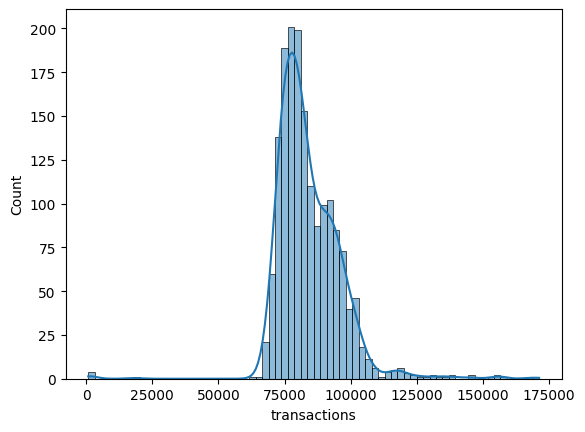

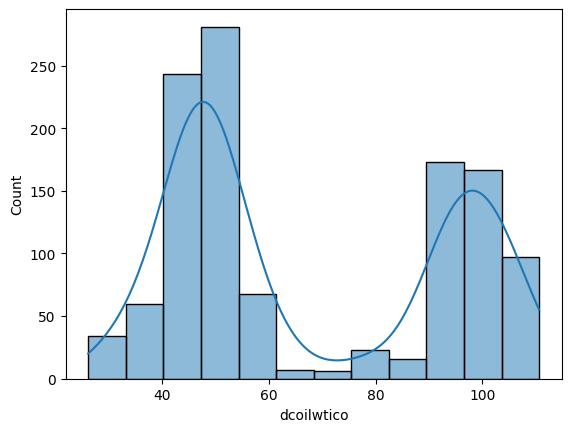

In [8]:
daily_transactions = trans_df.groupby("date")['transactions'].sum()

sns.histplot(data=daily_transactions,kde=True)
plt.show()
sns.histplot(data=oil_df,x='dcoilwtico' ,kde=True)
plt.show()

the oil price df is bimodal, not normal, so we will use spearman instead of pearson

In [9]:
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    normalized = (series - min_val) / (max_val - min_val)
    return normalized

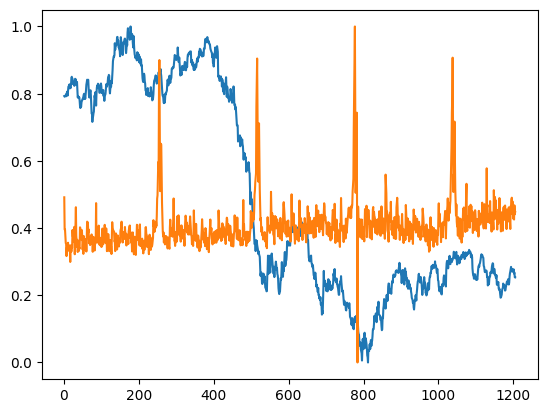

In [10]:
oil_and_trans_corr_df = oil_df.merge(daily_transactions, 
            left_on='date', 
            right_index=True,
            how='inner')

oil_and_trans_corr_df = oil_and_trans_corr_df[~(oil_and_trans_corr_df['dcoilwtico'].isnull())] #remove dates where there is no info about the oil

plt.plot(normalize_series(oil_and_trans_corr_df['dcoilwtico']))
plt.plot(normalize_series(oil_and_trans_corr_df['transactions']))
plt.show()

There are outlyers ins the oil info but they dont interfere as much in a spearman correlation

In [11]:
float(oil_and_trans_corr_df['dcoilwtico'].corr(oil_and_trans_corr_df['transactions'], method='spearman'))

-0.4187712354354692

its a light linear relation but lets take it in count to train the model

lets see if the number of items on promotion is related to the daily sales of a product

but first lets check for null data

In [12]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [13]:
#promoted_train_df= train_df[train_df['onpromotion']>0] #lets use this dataframe to visualize better the data
#sns.histplot(data=promoted_train_df, x='onpromotion',kde=True)
#plt.xlim((0,promoted_train_df['onpromotion'].std()+promoted_train_df['onpromotion'].median()))
#plt.show()
#sns.histplot(data=train_df, x='sales',kde=True)
#plt.xlim((0,train_df['sales'].std()+train_df['sales'].median()))
#plt.show()

we can see that the both distributions are not normal, so we cant use pearson, lets use spearman

In [14]:
float(train_df['sales'].corr(train_df['onpromotion'], method='spearman'))

0.5380218163559225

so as we can see, we should use 'onpromotion' and 'oil' to try to predict the sales, since both are linearly related to the sales of a product, now we have to test the holidays

In [15]:
hol_df=hol_df[hol_df["transferred"]==False] #removing not important info
hol_df.groupby(by='date').size().sort_values(ascending=False).head()

date
2014-06-25    4
2013-06-25    3
2017-06-25    3
2016-06-25    3
2012-06-25    3
dtype: int64

there are dates with more than one holiday, this means that in order to relate the sales of a day to a holyday variable, we will have to relate it to a list of categorical variables 

In [16]:
hol_to_store_col = {
    'Regional':'state',
    'Local':'city',
    'National':'country'
}


In [17]:
hol_transfered = hol_df[hol_df['type']=='Transfer']
for _, hol in hol_df[hol_df['type']!='Transfer'].iterrows():
    mask = hol_df['description'].str.contains(hol['description'], regex=False)
    hol_df.loc[mask, 'description'] = hol['description']

for _, hol in hol_df[hol_df['type']!='Transfer'].iterrows():
    mask = hol_df['description'].str.contains(hol['description'], regex=False)
    print(hol_df[mask])

           date     type locale locale_name         description  transferred
0    2012-03-02  Holiday  Local       Manta  Fundacion de Manta        False
46   2013-03-02  Holiday  Local       Manta  Fundacion de Manta        False
93   2014-03-02  Holiday  Local       Manta  Fundacion de Manta        False
164  2015-03-02  Holiday  Local       Manta  Fundacion de Manta        False
214  2016-03-02  Holiday  Local       Manta  Fundacion de Manta        False
301  2017-03-02  Holiday  Local       Manta  Fundacion de Manta        False
           date     type    locale locale_name                    description  \
1    2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
47   2013-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
96   2014-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
165  2015-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
216  2016-04-01  Holiday  Regional    Cotopaxi  Provinci

In [18]:
for i in hol_df['type'].drop_duplicates():
    trans_df[i]=0

#iterate for all holydays
for _, hol in hol_df.iterrows():
    stores_affected = []
    store_locale_column = hol_to_store_col[hol['locale']]

    if(store_locale_column=='country'):
        stores_affected=stores_df['store_nbr'].unique()
    else:
        stores_affected=stores_df[stores_df[store_locale_column]==hol['locale_name']]['store_nbr']
    
    store_mask = trans_df['store_nbr'].isin(stores_affected)
    date_mask = trans_df['date'] == hol['date']

    trans_df.loc[date_mask & store_mask, hol['type']] = 1

In [19]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Found this about types and clusters in the stores dataset <br>
Good point. Not sure what cluster is, but I looked into type and performed EDA on types. You can go to the grocery chain's web site:

https://www.corporacionfavorita.com/en/brands/commercial-area/

And from Wikipedia, as of 2016:

From Wikipedia:

Supermaxi (35 locations as of 2016)
Megamaxi (12 locations as of 2016)
Akí (38 locations as of 2016)
Gran Akí (17 locations as of 2016)
Súper Akí (5 locations as of 2016)

I don't know for sure, but when I did some work on this a few weeks ago, my best guess ended up as:

D 18 Aki
C 15 SuperMaxi
A 9 Megamaxi
B 8 Gran Aki
E 4 Super Aki

In [20]:
from scipy.stats import mannwhitneyu, spearmanr

trans_during_holidays = trans_df[(trans_df[hol_df['type'].unique()]>0).any(axis=1)]
trans_without_holidays = trans_df[~((trans_df[hol_df['type'].unique()]>0).any(axis=1))]
rel_sells_holyday, p_value = mannwhitneyu(trans_during_holidays['transactions'], trans_without_holidays['transactions'])
print(f"rel_sells_holyday = {rel_sells_holyday}, p_value {p_value}")

rel_sells_holyday = 292406229.5, p_value 5.5295583768591555e-39


since p_value < 0.05 we can say that the fact of having a holiday affects the sales of a day, now, lets see if the type of holiday affects as well

In [21]:
len(hol_df['description'].unique())

51

if we wanted to add all possible holidays to our LSTM model for it to use this, we would have to use a one hot encoder with 103 values. <br> 
We have some options:
- Clusterize the holidays by the similarity of impact in sales
- Use the holiday type instead of the holiday name
- Use the holiday day

In [22]:
dict_hol_type_relation = {}

for t in hol_df['type'].unique():
    rel, pv = spearmanr(trans_df['transactions'], trans_df[t]) 
    print(f"{t}: rel {rel} pv {pv}")
    if(pv<0.05):
        print(f'This is valid')
    dict_hol_type_relation[t]=rel

Holiday: rel -0.007995687235202447 pv 0.020871584139339504
This is valid
Transfer: rel -0.0019687572138251917 pv 0.56945763094409
Additional: rel 0.09533183850756244 pv 8.93471538221235e-168
This is valid
Bridge: rel 0.009447693425864868 pv 0.006336045982997818
This is valid
Work Day: rel 0.015033974828911171 pv 1.398218558013961e-05
This is valid
Event: rel 0.0016481013026850258 pv 0.6339316395810989


p < 0.05 → Statistically significant <br>
The correlation is unlikely to be due to random chance.<br>
Commonly accepted threshold for validity in most scientific studies.<br>
<br>
p ≥ 0.05 → Not statistically significant<br>
The observed correlation could be due to random variation.<br>
The result is not considered strong evidence of a true relationship.<br>

There is no way that the relation between this typ of holidays are not linear, so this means that a day being a holiday has no relation with the sales during that day.

Now i will use a one hot encoder to use the description of the holiday as a input to a LSTM to predic the sales of a day

In [23]:
trans_df.drop(hol_df['type'].unique(),axis=1, inplace=True)

In [24]:
hol_rank = {
    'Local':1, 
    'Regional':2, 
    'National':3
}

In [25]:
test_df['hol_description']='none'
train_df['hol_description']='none'
test_df['hol_locale']=0
train_df['hol_locale']=0

#iterate for all holydays
for _, hol in hol_df.iterrows():
    stores_affected = []
    store_locale_column = hol_to_store_col[hol['locale']]

    if(store_locale_column=='country'):
        stores_affected=stores_df['store_nbr'].unique()
    else:
        stores_affected=stores_df[stores_df[store_locale_column]==hol['locale_name']]['store_nbr']
    
    store_mask = test_df['store_nbr'].isin(stores_affected)
    date_mask = test_df['date'] == hol['date']
    locale_mask = test_df['hol_locale'] < hol_rank[hol['locale']]

    test_df.loc[store_mask & date_mask & locale_mask, 'hol_description'] = hol['description']

    store_mask = train_df['store_nbr'].isin(stores_affected)
    date_mask = train_df['date'] == hol['date']
    locale_mask = train_df['hol_locale'] < hol_rank[hol['locale']]

    train_df.loc[store_mask & date_mask & locale_mask, 'hol_description'] = hol['description']


preprocessing oil_df

In [26]:
oil_df = pd.read_csv('oil.csv')

In [27]:
#for _, oil_row in oil_df[oil_df['date'].isin(pd.concat([train_df['date'], test_df['date']], ignore_index=True))].iterrows():
oil_df = oil_df[oil_df['date'].isin(pd.concat([train_df['date'], test_df['date']], ignore_index=True))]

null_percentage_training_ds = (oil_df[oil_df['dcoilwtico'].isnull()].size/oil_df.size)*100
null_percentage_training_ds

3.292181069958848

Since its a low null percentage, we will interpolate

In [28]:
oil_df.set_index('date', inplace=True)
oil_df.index = pd.to_datetime(oil_df.index)
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='time')
oil_df = oil_df[~oil_df['dcoilwtico'].isnull()]

In [29]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df=train_df.merge(left_on='date',
                right=oil_df,
                right_index=True,
                )
test_df['date'] = pd.to_datetime(test_df['date'])
test_df=test_df.merge(left_on='date',
                right=oil_df,
                right_index=True,
                )

In [30]:
print(test_df[test_df['dcoilwtico'].isnull()].size)
print(train_df[train_df['dcoilwtico'].isnull()].size)

0
0


In [31]:
test_df.head(1)

,id,date,store_nbr,family,onpromotion,hol_description,hol_locale,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,none,0,46.8


In [32]:
train_df.head(1)

,id,date,store_nbr,family,sales,onpromotion,hol_description,hol_locale,dcoilwtico
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,none,0,93.14


now the two datasets are ready lets go

In [33]:
len(stores_df['cluster'].unique())

17

In [34]:
len(stores_df['type'].unique())

5

In [35]:
len(stores_df['store_nbr'].unique())

54

Looking maximize precision, we got 3 options:
- Use the store nbr as a nominal variable for the lstm model, to detect useful patterns in each store. But this could need more data, becaouse this reduces the data for each store.<br><br>
- Assumming that that patterns repeat between each 5 clusters and use that instead of the store number, but this will mean assuming information that we dont know.<br><br>
- Doing the same for the store type, the information online is that this indicates the name of the store brand (like wallmart vs costco) but since all thoose supermarket sell the same items, there is no reason to assume that the sales patterns repeat in each store type.

For the first model i will use the store type. And since this is a 1-1 relationship i dont have to use one hot encoding

In [36]:
train_df["store_type"] = 0
test_df["store_type"] = 0
for t in stores_df['type'].unique():
    store_numbers = stores_df[stores_df['type']==t]['store_nbr']
    train_df.loc[train_df['store_nbr'].isin(store_numbers), "store_type"] = t
    test_df.loc[test_df['store_nbr'].isin(store_numbers), "store_type"] = t

/tmp/ipykernel_5011/3428556127.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'D' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['store_nbr'].isin(store_numbers), "store_type"] = t
/tmp/ipykernel_5011/3428556127.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'D' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df['store_nbr'].isin(store_numbers), "store_type"] = t


In [37]:
train_df

,id,date,store_nbr,family,sales,onpromotion,hol_description,hol_locale,dcoilwtico,store_type
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,none,0,93.14,D
1783,1783,2013-01-02,1,BABY CARE,0.000,0,none,0,93.14,D
1784,1784,2013-01-02,1,BEAUTY,2.000,0,none,0,93.14,D
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,none,0,93.14,D
1786,1786,2013-01-02,1,BOOKS,0.000,0,none,0,93.14,D
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,none,0,47.57,B
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,none,0,47.57,B
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,none,0,47.57,B
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,none,0,47.57,B


In [38]:
print("product families: "+str(len(train_df['family'].unique())))
print("product families that are not in test df but are in train df: "+str(len(train_df[~(train_df['family'].isin(test_df['family']))]['family'])))

product families: 33
product families that are not in test df but are in train df: 0


In [39]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import re

categorical_variables = ['family','store_nbr','store_type','hol_description']
for c in categorical_variables:
    train_df[c] = train_df[c].astype('category')
    test_df[c] = test_df[c].astype('category')

preprocessed_train_df = train_df
preprocessed_train_df['weekDay']= preprocessed_train_df['date'].dt.weekday
preprocessed_train_df['monthDay']= preprocessed_train_df['date'].dt.day
preprocessed_train_df['month']= preprocessed_train_df['date'].dt.month
preprocessed_train_df = preprocessed_train_df.drop(['date','sales','id'], axis=1)
preprocessed_train_df = preprocessed_train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
duplicated_columns = preprocessed_train_df.columns[preprocessed_train_df.columns.duplicated(keep=False)]

y_series =  pd.Series(data=train_df['sales'].to_numpy(), index=train_df['date'])

x_train, x_test, y_train, y_test = train_test_split(preprocessed_train_df, y_series, test_size=0.2,shuffle=False)
y_test:pd.Series=y_test



#(baseline)
params = {
    'objective': 'poisson', 
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbosity': -1
}

train_ds = lgb.Dataset(
    x_train,
    label=y_train,
    categorical_feature=categorical_variables,
)
test_ds = lgb.Dataset(
    x_test,
    label=y_test,
    categorical_feature=categorical_variables
)


In [40]:
y_train

date
2013-01-02       2.000
2013-01-02       0.000
2013-01-02       2.000
2013-01-02    1091.000
2013-01-02       0.000
                ...   
2016-09-13     730.000
2016-09-13     233.417
2016-09-13     566.000
2016-09-13      91.000
2016-09-13    4416.429
Length: 1713571, dtype: float64

In [41]:
model = lgb.train(
    params,
    train_ds,
    num_boost_round=1000,
    valid_sets=[test_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 443.726


In [42]:
y_pred = model.predict(x_test)
y_pred = pd.Series(y_pred)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
#print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")

RMSE: 443.73
MAE: 106.75


In [43]:
train_df['family'].unique()

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']

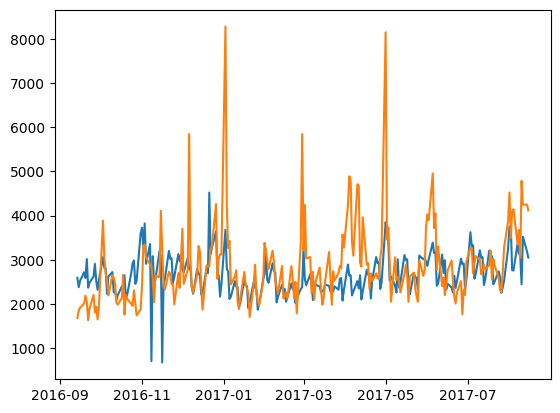

In [44]:
mask:pd.Series = (x_test['family']=='BEVERAGES') & (x_test['store_nbr']==20).to_numpy()
mask.reset_index(inplace=True,drop=True)
mask=mask.to_numpy()
y_pred.index=y_test.index
plt.plot(y_pred[mask].sort_index())
plt.plot(y_test[mask].sort_index())


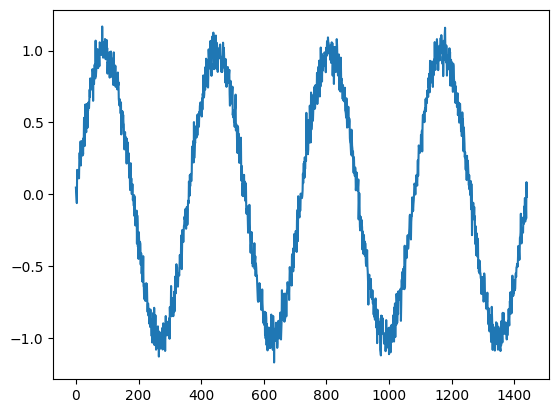

In [45]:
import math
import numpy as np

x = torch.tensor(np.array(range(0,(360*4) +1)))
aux =np.vectorize(lambda x : math.sin(math.radians(x)))
y = aux(x)
noise = np.random.normal(0, 0.07, len(y))
y = noise+y
plt.plot(y)


In [46]:
import numpy as np

def create_windows(x, y, window_size, stride=1, horizon=1):
    num_samples = len(x)
    num_windows = (num_samples - window_size - horizon) // stride + 1
    
    windows = np.zeros((num_windows, window_size, 1))
    ground_truths = np.zeros((num_windows, horizon))
    
    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        windows[i, :, 0] = x[start:end]
        ground_truths[i] = y[end:end+horizon]
        
    return windows, ground_truths

/tmp/ipykernel_5011/3626923811.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  windows[i, :, 0] = x[start:end]


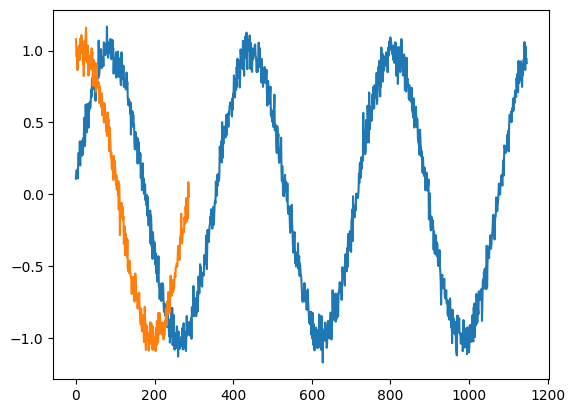

In [47]:
x, y = create_windows(x,y,5)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

class SinDs(torch.utils.data.Dataset):
    def __init__(self, windows,y):
        self.data = windows
        self.labels = y
        self.transform = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
sin_train_ds = SinDs(x_train,y_train)
sin_test_ds = SinDs(x_test,y_test)
sin_train_dl = torch.utils.data.DataLoader(sin_train_ds,batch_size=36,shuffle=False)
sin_test_ds = torch.utils.data.DataLoader(sin_test_ds,batch_size=36,shuffle=False)

plt.plot(np.array(y_train))
plt.plot(np.array(y_test))

epoch 0 loss 0.6293988227844238
epoch 1 loss 0.6922299861907959
epoch 2 loss 0.7062376737594604
epoch 3 loss 0.7243924140930176
epoch 4 loss 0.753584086894989
epoch 5 loss 0.7747179865837097
epoch 6 loss 0.7723109722137451
epoch 7 loss 0.8007297515869141
epoch 8 loss 0.7783553004264832
epoch 9 loss 0.8175500631332397
epoch 10 loss 0.7731451392173767
epoch 11 loss 0.8121597170829773
epoch 12 loss 0.7737665176391602
epoch 13 loss 0.8118555545806885
epoch 14 loss 0.7848276495933533
epoch 15 loss 0.8214845657348633
epoch 16 loss 0.77725750207901
epoch 17 loss 0.813441812992096
epoch 18 loss 0.7879271507263184
epoch 19 loss 0.8201831579208374
epoch 20 loss 0.784396767616272
epoch 21 loss 0.8149577379226685
epoch 22 loss 0.793052077293396
epoch 23 loss 0.8210140466690063
epoch 24 loss 0.7884686589241028
epoch 25 loss 0.8149243593215942
epoch 26 loss 0.7959452867507935
epoch 27 loss 0.8207710981369019
epoch 28 loss 0.7924039363861084
epoch 29 loss 0.8149020075798035
epoch 30 loss 0.7999014854

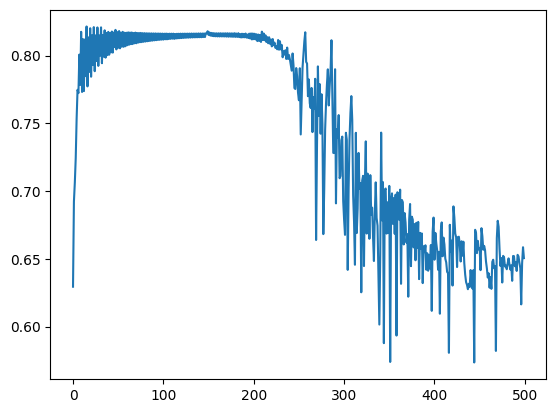

In [48]:
from typing import Optional

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LstmSin(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h_sz = 50
        self.lstm = torch.nn.LSTM(input_size=1,hidden_size=self.h_sz,num_layers=2,batch_first=True) 
        self.fc = torch.nn.Linear(self.h_sz,1)

    def forward(self,x, hx: Optional[tuple[torch.Tensor, torch.Tensor]] = None):
        lstm_out, hx = self.lstm(x,hx)
        lstm_out=lstm_out[:,-1,:]
        #now lstm_out its a float
        
        return self.fc(lstm_out), hx

#tamanho h= [batch, features]
#tamanho c= [batch, features]
#input= window c, h

def training_loop(f:LstmSin, dl:torch.utils.data.DataLoader, epochs, lr=0.001):
    optim = torch.optim.Adam(f.parameters(), lr=lr)
    error=torch.nn.MSELoss()
    epoch_losses = []
    for i in range(epochs):
        losses = []
        for x,y in dl:

            optim.zero_grad()
            x = x.float().to(device)
            y = y.float().to(device)
            
            yhat, h = f(x)
            #print(f"yhat 0,: {yhat[0,:].item()} e y 0,: {y[0,:].item()}")
            loss:torch.Tensor = error(yhat,y)
            loss.backward()
            optim.step()
            losses.append(np.mean(loss.item()))
  
        print(f"epoch {i} loss {losses[-1]}")
        epoch_losses.append(losses[-1])
    return epoch_losses

new_model = LstmSin().to(device)
epoch_losses = training_loop(new_model,sin_train_dl,500,lr=0.001)
plt.plot(epoch_losses)
plt.show()


In [61]:
new_model.eval()
yhat_test, _ = new_model(torch.Tensor(x_test[0:2]).to(device))
print(yhat_test)
yhat_test, _ = new_model(torch.Tensor(x_test[1:3]).to(device))
print(yhat_test)

#plt.plot(y_test)
#plt.plot(yhat_test.to('cpu').detach().numpy())

tensor([[0.0329],
        [0.0329]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0329],
        [0.0329]], device='cuda:0', grad_fn=<AddmmBackward0>)


Looking at the cardinality of the holiday type and product family maybe afterwards i could take a look at using this:
##### Alternative Embeddings for High Cardinality
- Embedding Layers (if using a neural network, like in NLP).
- Feature Hashing (hashing trick).
- Target Encoding (mean encoding) with regularization.

Lets define wich variables will be static variables and wich ones will be part of the time series.

Static features:
- store type
- product family <br>

Sequential features:
- onpromotion
- holiday hot encoded value
- oil price

Since we have 5 store types and a lot of products i tought in creating a model and fine tuning it to  

In [176]:
all_hol_names = hol_df['description'].unique()
for c1,c2 in zip(train_df.columns, test_df.columns):
    if(c1 not in all_hol_names):
        print("holiday not in columns: " + c1)
    if(c2 not in all_hol_names):
        print("holiday not in columns: " + c2)

seq_feat_nbr =  1 + len(hol_df['description'].unique()) + 1
stat_feat_nbr = len(train_df['family'].unique()) + len(stores_df['type'].unique())
print("ltsm_input_features_nbr "+str(seq_feat_nbr))
print("static_features_nbr "+str(stat_feat_nbr))

holiday not in columns: id
holiday not in columns: id
holiday not in columns: date
holiday not in columns: date
holiday not in columns: store_nbr
holiday not in columns: store_nbr
holiday not in columns: family
holiday not in columns: family
holiday not in columns: sales
holiday not in columns: onpromotion
holiday not in columns: onpromotion
holiday not in columns: hol_description
holiday not in columns: hol_description
holiday not in columns: hol_locale
holiday not in columns: hol_locale
holiday not in columns: dcoilwtico
holiday not in columns: dcoilwtico
holiday not in columns: store_type
ltsm_input_features_nbr 53
static_features_nbr 38


In [177]:
class Forecasting_model(torch.nn.Module):
    def __init__(self, seq_feat_nbr, stat_feat_nbr):
        super().__init__()
        self.hidden_layer_size = 50
        self.lstm_out_nbr=1
        self.lstm = torch.nn.LSTM(input_size=seq_feat_nbr, hidden_size=self.hidden_layer_size, num_layers=2, batch_first=True)
        self.static_nn = torch.nn.Sequential(
                            torch.nn.Linear(stat_feat_nbr,self.hidden_layer_size),
                            torch.nn.ReLU()
                            )
        self.fc = torch.nn.Linear(self.hidden_layer_size*2, self.lstm_out_nbr)
    
    def forward(self, seq, stat_features, memory):
        #seq expected size: (batch_size, window_size, features_size)
        #stat_feat expected size: (batch_size, static_features_size)
        lstm_out, memory = self.lstm(seq, (memory))
        lstm_out = lstm_out[:,-1,:]#[select all batches , just the last part of the sequence, select all features from this sequence (hidden_size)]
        static_out = self.static_nn(stat_features)
    
        fc_out = self.fc(torch.cat((static_out,lstm_out)))

        return fc_out, memory

Now lets create the dataset, i am thinking about a tuple of tensors
- the sequential time window of features
- the static features

We also have to separate all dataframes by the static features

In [178]:
train_df.sort_values(by=['store_type','family'])

,id,date,store_nbr,family,sales,onpromotion,hol_description,hol_locale,dcoilwtico,store_type,weekDay,monthDay,month
3036,3036,2013-01-02,44,AUTOMOTIVE,16.0,0,none,0,93.14,A,2,2,1
3069,3069,2013-01-02,45,AUTOMOTIVE,13.0,0,none,0,93.14,A,2,2,1
3102,3102,2013-01-02,46,AUTOMOTIVE,11.0,0,none,0,93.14,A,2,2,1
3135,3135,2013-01-02,47,AUTOMOTIVE,11.0,0,none,0,93.14,A,2,2,1
3168,3168,2013-01-02,48,AUTOMOTIVE,5.0,0,none,0,93.14,A,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998577,2998577,2017-08-14,43,SEAFOOD,1.0,0,none,0,47.59,E,0,14,8
2999798,2999798,2017-08-15,28,SEAFOOD,12.0,0,none,0,47.57,E,1,15,8
2999831,2999831,2017-08-15,29,SEAFOOD,4.0,0,none,0,47.57,E,1,15,8
3000095,3000095,2017-08-15,36,SEAFOOD,0.0,0,none,0,47.57,E,1,15,8


In [ ]:
#window_size = 5
#for i in range((len(train_df)-window_size)+1):
#    print(train_df[i:i+window_size])
#class TupleTensorDataset(torch.)

SyntaxError: invalid syntax (483512891.py, line 4)